# [1] Introduction
Cells in this notebook are not ordered in the way I was thinking or trying; instead it is organized in the way that I would like to present.</br>
It is the important parts that introduced some results during dealing with the case.


### Business problem:
Users should be clustered in a way that allows the mailing system to send emails on appropriate time to achieve tow goals:
1. Make sure the email will not be buried under other __newer__ emails.
2. Avoid disturbing users by notifications of emails while they will not be able to read it.
___
## Steps:
1. Reading original data, clean it if required, and explore it.
2. Convert the data into a standard format (storing the standard format to reduce later loading time).
3. Explore data to understand distribution for each variable.
4. Build evaluation function considering the sending hours limitation (corners) and the possible delay of emails reading.
5. Evaluation the current data considering the best possible sending time to understand how much room for enhancement we have.
6. Checking what ML algorithms could possibly be suitable for the case.
7. Picking one model and evaluating it

#### Notes:
- While the user behavior is related to only their own 24 hours (his/her behavior is related to the same day no matter when we send the email), the evaluation function considers the 24 hours possible delay. For example, if the user can read his email according to whatever model 6:00 AM, this does not mean we can send the email 6:00 AM.</br>
- Apparently, the sending times are limited to [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]. A customer who is ready to read his email 6:00 AM means we need to send the email 20:00.
___
# Evaluation function:

In [1]:
#######################################################################################
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sbn
from datetime import datetime, timedelta
from sklearn.covariance import EllipticEnvelope
import time
from scipy import stats
import os
import pickle
#######################################################################################
SHs = list(range(7,21))
def Evaluate(data, new_oh):
    '''Evaluate the predicted open hours by first converting it to sending hours'''
    if data.shape[0]!=len(new_oh):
        print("Lengths do not match")
        return
    
    delay = data[['SH','OH','D']].copy()
    delay['D'] = delay.OH - delay.SH
    delay.loc[delay.D<0,'D'] = 24 + delay.loc[delay.D<0,'D']
    
    new_sh = GetSendingHours(new_oh)
    delay['OD'] = delay.OH - new_sh
    delay.loc[delay.OD<0,'OD'] = 24 + delay.loc[delay.OD<0,'OD']
    print(f"Suggested sending hours modify avg. delay from {delay.D.mean():4.2f} to {delay.OD.mean():4.2f} [{1-(delay.OD.mean()/delay.D.mean()):4.2%}]")
    return delay.OD.mean()
#######################################################################################
def GetSendingHours(lst):
    res = []
    for l in lst:
        if l not in SHs:
            sh = max(SHs)
        else:
            sh = l
        res.append(sh)
    return res
#######################################################################################

## Main processing class and functions

In [2]:
#=====================================================================================
class PF:
    ''' A class that will handle some of the common data-related activities
    It handles data read/write 
    '''
    Full = None
    Sample = None
    Testing = True
    #=================================================================================
    std_data_fn = 'std_data.csv'
    #=================================================================================
    # Upon creating the object, the data file is read
    # An optional parameter is the source data file name
    def __init__(self, fn = None, recreate=False):        
        self.BuildDF(fn=fn, recreate=recreate)
    #=================================================================================
    # We will use minute index instead of the provided timestamps
    def Str2Time(s):
        return (int(s[:2])*60)+int(s[3:])
    #=================================================================================
    # In case we need to show minute index in the timestamp provided format
    def Time2Str(n):
        return f"{int(n/60):02.0f}:{(n%60):02.0f}"
    #=================================================================================
    def ShowOH4SH(self):
        plt.figure(figsize=(20,8), dpi=144)
        for sh in sorted(set(self.DF.SH)):
            sbn.distplot(self.DF[self.DF.SH==sh].OH, hist=False,label=f"SH: {sh}")
        title = "Email Opening hour distribution for each sending hour"
        plt.suptitle(title,fontsize=20)
        plt.tight_layout(3.7)
        plt.grid(alpha=0.25)
        plt.savefig(title+'.png')
        plt.show()
    #=================================================================================
    def FullData(self,recreate=False):
        return self.BuildDF(recreate)
    #=================================================================================
    def SampleData(self,pct=0.03,recreate=False):
        if pct<=0:
            return None        
        df = self.BuildDF(recreate)
        if pct<1:
            df = df.sample(int(df.shape[0]*pct))
        self.Sample = df.copy()
        del df
        return self.Sample
    #=================================================================================
    FinalDF = None
    def Final(self, recreate=False):
        final_fn = 'final_data.csv'        
        if not recreate:
            if not self.FinalDF is None:
                return self.FinalDF
            
            if os.path.exists(final_fn):
                self.FinalDF = pd.read_csv(final_fn)
                return self.FinalDF
            
        self.FinalDF  = self.BuildDF().groupby(['UID'])[['X1','X2','X3','OH']].min()
        self.FinalDF.to_csv(final_fn,index=False)
        return self.FinalDF
    #=================================================================================
    HourMap = None
    def GetBestOH(self):
        '''For each user, we pick on of his open hours that best mach our objective
        Data is taken from the standard format.
        '''
        cols = list(range(7,24)) + list(range(0,7))
        tmp = self.DF.groupby(['UID','X1','X2','X3','OH'])[['UID']].count()
        tmp = tmp.unstack().droplevel(0,1).reset_index()        
        tmp.replace(np.NaN, 0,inplace=True)
        tmp['BestOpen'] = np.NaN
        for c in cols:
            tmp.loc[tmp[(tmp[c]>0)&(tmp.BestOpen.isna())].index,'BestOpen'] = c
        tmp['BestSend'] = GetSendingHours(tmp.BestOpen)
        
        cc = pd.merge(tmp,self.DF,how='inner',left_on=['UID','BestOpen'], right_on=['UID','OH']).groupby(['UID']).first()
        cc.drop(columns = [c for c in cc.columns if '_y' in str(c)],inplace=True)
        cc.rename(columns = { c:str(c).replace('_x','') for c in cc.columns if '_x' in str(c)},inplace=True)
        
        self.HourMap = cc.copy() 
        del tmp
        return cc
    #=================================================================================
    # Create a suitable data structure
    DF = None
    PCT = None
    def BuildDF(self,fn=None,recreate = False):
        '''
        Build the data structure suitable for analysis
        '''
        if not recreate:
            if os.path.exists(self.std_data_fn):
                self.DF = pd.read_csv(self.std_data_fn)
                return self.DF
        
        if self.DF is not None:
            return self.DF
        
        if fn is None:
            fn = "data.zip"
            
        full = pd.read_csv(fn)
        
        if self.Testing:
            start_time = datetime.now()
        
        full['UID']=full.index
        
        lst = []
        
        for m in range(0,15):
            # Columns couples' names creation
            cols = [f"TS{m:02.0f}",f"TO{m:02.0f}"]
            
            # Finding index for non NAN values
            idx = full[cols].dropna().index            
            # Also can be `full[(full.M>=(m+1))].index` but this would be silly
            
            # Getting important data
            # UID is just used here to check repeated records for the same user
            tmp = full.loc[idx, ['UID','X1','X2','X3','M'] + cols].copy()
            
            # Now, convert the text
            for i in range(2):
                col = cols[i]
                tmp[col] = tmp[col]
    
            tmp.rename(columns = {cols[0]:'TS',cols[1]:'TO'},inplace=True)
            lst.append(tmp.copy())
        
        output = pd.concat(lst)
        output.TS = output.TS.apply(PF.Str2Time)
        output.TO = output.TO.apply(PF.Str2Time)
        
        TS_Errors = output[(output.TS<0)|(output.TS>=1440)]        
        if TS_Errors.shape[0]:
            print(f"{TS_Errors.shape[0]} TS value(s) are not correct")
        
        TO_Errors = output[(output.TO<0)|(output.TO>=1440)]
        if TO_Errors.shape[0]:
            print(f"{TO_Errors.shape[0]} TO value(s) are not correct")
            
        
        output.loc[(output.TO<output.TS),"TO"] = output.loc[(output.TO<output.TS),"TO"] + 1440
        output["D"] = (output.TO - output.TS)
        
        if self.Testing:
            duration = datetime.now() - start_time
            print(f'BuildFD finished processing durin {duration}')
        
        # Same as TS but int
        output["SH"] = (output.TS/60).astype(int)
        # Hour during the day or the next day at on which user opens the email
        # But the customer behavior is just the Hour -no matter what day        
        output["OH"] = ((output.TO)/60).astype(int) % 24
        
        self.DF = output.copy()
        self.DF.to_csv(self.std_data_fn, index=False)
        self.HourMap = self.GetBestOH()
        
        del full
        del output
        return self.DF
#######################################################################################
def ShowDist(data, var):
    ''' Show var for different parts of the data. Each part of the data matches on opening-hour (OH)
    '''
    plt.figure(figsize=(20,4))
    for oh in sorted(set(data.OH)):
        for x3 in sorted(set(data.X3)):
            sbn.distplot(data[(data.X3==x3)&(data.OH==oh)][var], kde=True, bins=100,hist=False)
    plt.suptitle(f"Distribution of {var} for each open hour (OH) over different X3 classes")
    plt.grid(alpha=0.15)
    plt.tight_layout(2.8)
    plt.show()
#######################################################################################
def CleanData(data, contamination = 0.1):
    lof = EllipticEnvelope(contamination=contamination)
    good = lof.fit_predict(data[['X1','X2','X3']])
    return data[good==1].copy()
#######################################################################################
# How would the X1/X2 collision frequency for data
def X1X2Heatmap(data,title):
    '''Draw how would the X1/X2 collision frequency look like for data'''
    x = data.groupby(['X1','X2'])[['UID']].count().unstack().droplevel(0,1)
    sbn.heatmap(x.replace([np.NaN],-1))
    plt.suptitle(title)
    plt.show()
#######################################################################################  
def ShowMeasures(data, col,grp='X3'):
    ''' Show the measures for some column for all data, then for each X3 values '''
    full = data[[col]].describe().T.reset_index()    
    # If we try to check the avg and the std for for each category (X3)
    split = data.groupby([grp])[[col]].describe().droplevel(0,1).reset_index()    
    full = pd.concat([split,full])
    full.reset_index(drop=True,inplace=True)
    full.drop(columns=['index'],inplace=True)
    full.loc[4,grp] = "Full"
    full.set_index(grp,drop=True,inplace=True)
    return full
#######################################################################################
def Evaluate1(st, ot):
    d = ot - st
    if d<0:
        d = d+24
    return d
#######################################################################################
wrk_pct = 0.2 # During the general tests I use only 10% of the data
seed = 7 #Just in case I need it in code

___
___
# Reading and exploring data
*************************************************************************************************************
`obj = PF(recreate=True)` will create and object of the class used for the data I/O. The `recreate` parameter</br>
will read data from scratch even if a processed copy was already created before. This function reads and</br>
organizes the data


In [3]:
obj = PF(recreate=True)
# The processed data in a standard format for eacm email
df = obj.FullData()
# Sample data for quick testing when required
sdf = obj.SampleData(wrk_pct)
# A Full table to map hours/users/frequency etc.
final = obj.Final()
# Possible sending hours
print("Done")

2 TO value(s) are not correct
BuildFD finished processing durin 0:00:02.575700
Done


### Current average delay in hours

In [4]:
#The minimum we can reach is # when we send emails on the opening time
#BUT we are limited to some sending hours of course
print(f"The minimum average delay we can reach is {Evaluate(df,df.SH):.2f} hours")
print("Because we are limited to the sending hours below:")
print(SHs)

Suggested sending hours modify avg. delay from 8.58 to 8.58 [0.00%]
The minimum average delay we can reach is 8.58 hours
Because we are limited to the sending hours below:
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


### Optimal average delay in hours
In case we magically knew exactly when every user will check his email, and used these values. This is calculated just to check the available room for enhancement.

In [5]:
# What if we try to set sending time to open time?
print(f"The minimum average delay we can reach is {Evaluate(df,df.OH):.2f} hours")
print("Because we are limited to the sending hours below:")
print(SHs)

Suggested sending hours modify avg. delay from 8.58 to 0.38 [95.57%]
The minimum average delay we can reach is 0.38 hours
Because we are limited to the sending hours below:
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


___
# Visualizing the data:

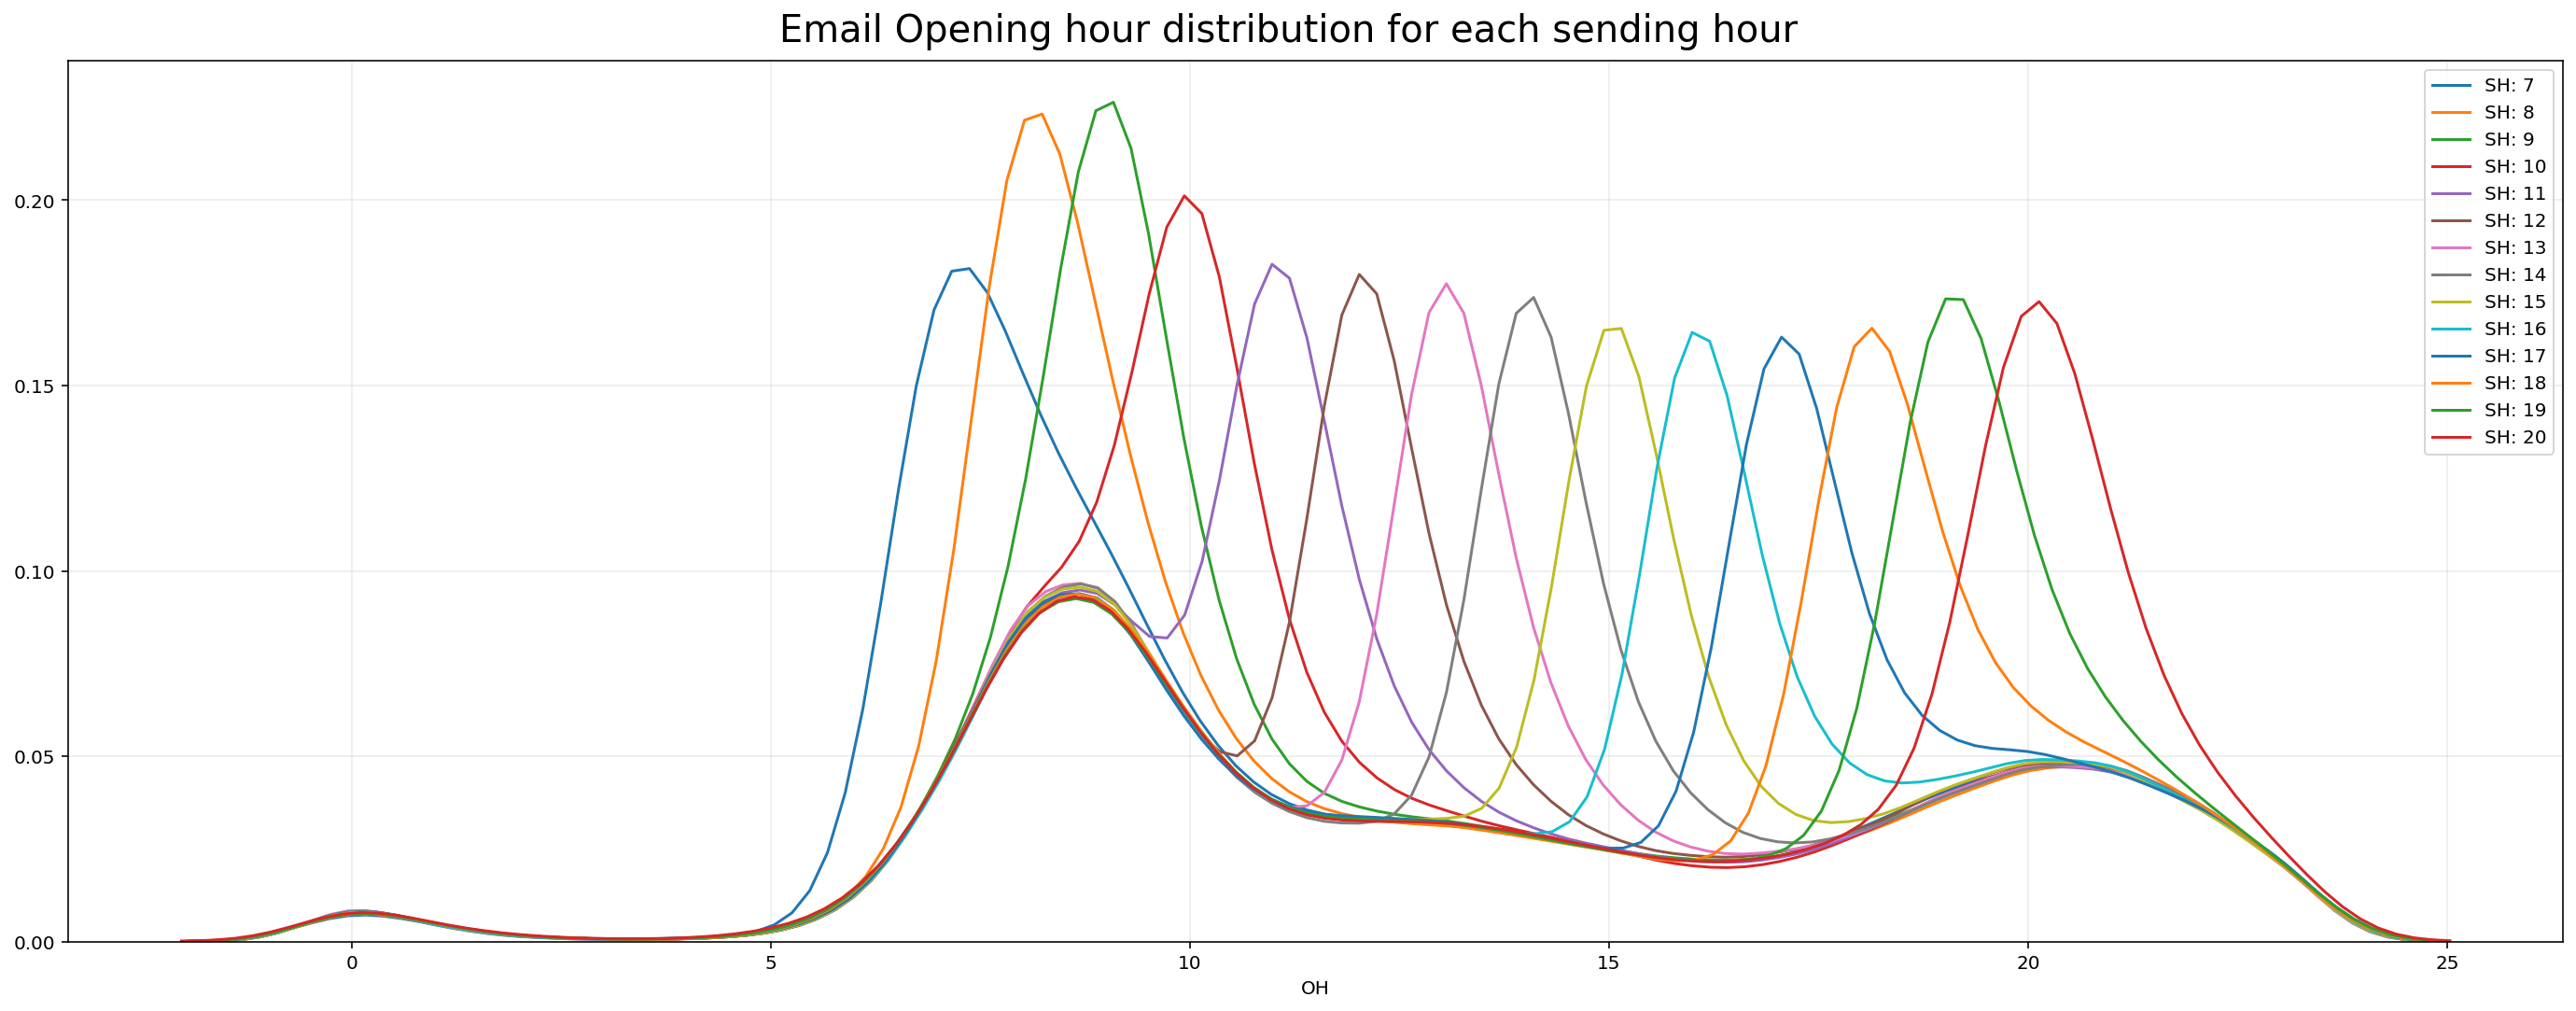

In [6]:
obj.ShowOH4SH()

### <span style="color:red">Notice:</span>
__OH is in hour number__. And email sent 7:00 AM can be read at the same minute; 7:00 or any next minute starting 7:01 till 7:59. Any `TO` between 7:00 and 7:59 produces an OH that is 7; which is interpreted as within the same hour.</br>
__The reason why I ignored minutes is the fact that it seems like the sending process takes place every one hour, so, there is not point in considering the minutes.__
Now, the story is as follows:
A user was checking his email one minute before we send an email to him; this means we lost our chance and we need to wait till he re-checks his email again. If we are planning which emails should bes sent on which hours, we will make is decision early before the first sending time stamp. This means. A smart sending mechanism, will send emails to people on the SH just before the OH. Where, (OH-SH) should be 0 at best.
The cost function should be $Min(OH-SH)$

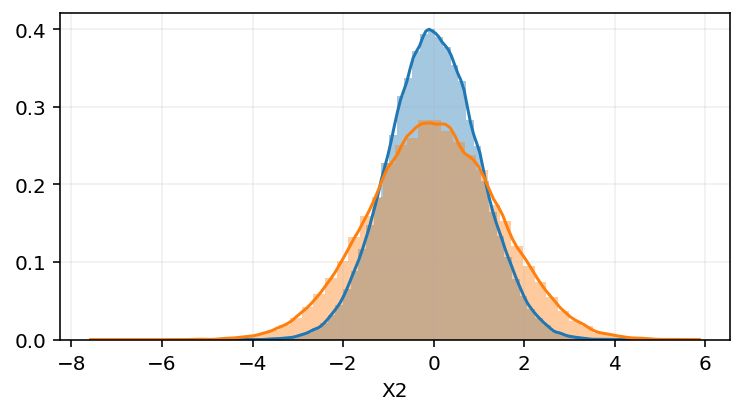

In [7]:
# X1, and X2 distributions
plt.figure(figsize=(6,3),dpi=144)
sbn.distplot(df.X1,label='X1')
sbn.distplot(df.X2,label='X2')
plt.grid(alpha=0.2)
plt.show()

### How does X1, X2 values distributions are different for each opening hour?

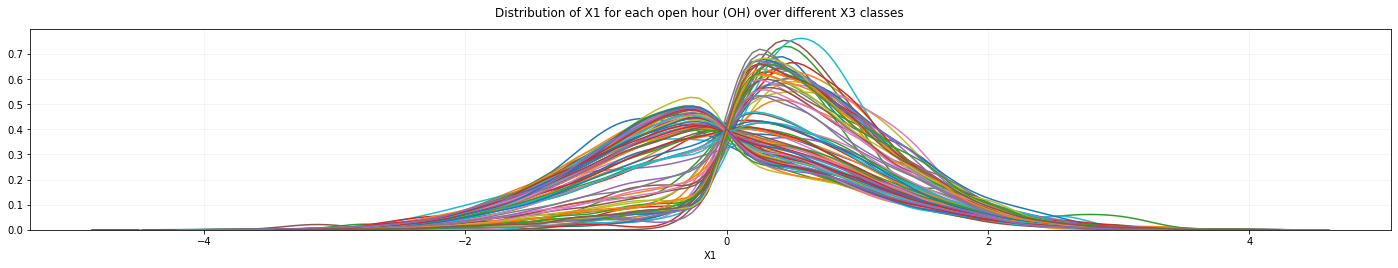

In [8]:
ShowDist(df, 'X1')

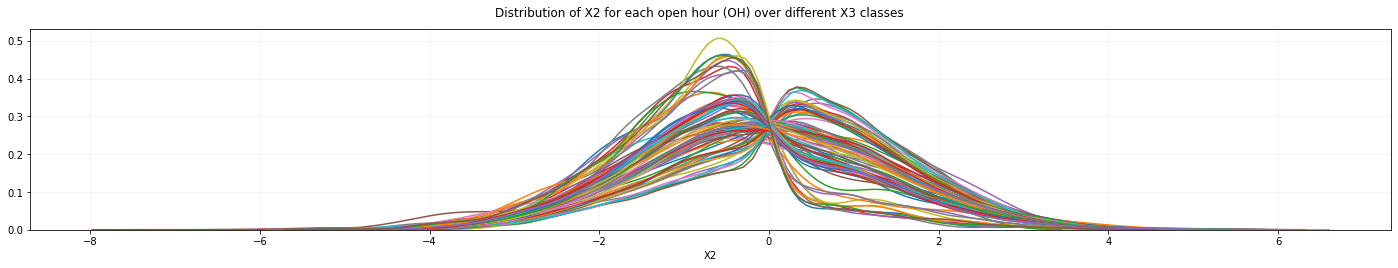

In [9]:
ShowDist(df, 'X2')

### What are the measures of the data frame we have (`df`)?

In [10]:
df.describe().T

count          mean           std     min       25%       50%  \
UID  798960.0  50089.040899  28855.718573    0.00  25144.00  50047.00   
X1   798960.0     -0.002840      1.002557   -4.38     -0.68     -0.01   
X2   798960.0      0.002335      1.416745   -7.28     -0.95      0.00   
X3   798960.0      1.494499      1.120356    0.00      0.00      1.00   
M    798960.0     10.319773      3.622843    1.00      8.00     11.00   
TS   798960.0    810.314284    241.912852  420.00    600.00    840.00   
TO   798960.0   1352.700697    569.122424  420.00    886.00   1234.00   
D    798960.0    542.386414    489.247172    0.00     63.00    402.00   
SH   798960.0     13.505238      4.031881    7.00     10.00     14.00   
OH   798960.0     13.443428      5.215973    0.00      9.00     13.00   

          75%       max  
UID  75123.00  99999.00  
X1       0.67      4.11  
X2       0.97      5.57  
X3       2.00      3.00  
M       13.00     15.00  
TS    1020.00   1200.00  
TO    1957.00   2639.00  
D     1000.00   1439.00  
SH      17.00     20.00  
OH      18.00     23.00

### With all this noise, can do we have a chance to remove some outliers? and will this be useful?
I asked if there is some hidden logic behind the extreme values because some features' nature makes these outliers more important like in health care applications.</br>
But let us answer the question, can we enhance the data by removing outliers?
First, I will see the joint plots for the features. __But__ I will consider the X3 a layers indicator. So, for each different X3 values, I will draw thew joint plot.
#### Assumption:
A user who checks his email twice in the provided data will check his email twice every day around the same time.
This means, we can select one hour from each user as we assume training the model for this user with his X1, X2, and X3 should be this specific OH
If another user has the same X values but he is opening at different times, we will also pick one OH from this user.</br>
<span style="color:red"> _Why_? </span> Because if we do this the ML algorithm will have less confusion, yet will keep enough information to understand the context.

In [11]:
ndf = obj.GetBestOH()
ndf

X1    X2  X3    0    1    2    3    4    5    6  ...   22   23  \
UID                                                       ...             
0     -1.25 -0.88   2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
1     -0.14 -3.21   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2      1.23  0.08   3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3     -0.38 -1.30   3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4     -1.50  0.22   2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0   
...     ...   ...  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99995 -0.53 -3.02   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
99996 -1.37  0.71   3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
99997 -1.27 -0.70   3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
99998 -0.62  2.95   1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0   
99999  0.23  0.50   2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0   

       BestOpen  BestSend   M    TS    TO     D  SH  OH  
UID                                                      
0           7.0       7.0  14   660  1907  1247  11   7  
1          17.0      17.0   1  1020  1031    11  17  17  
2           9.0       9.0   1  1140  2002   862  19   9  
3           9.0       9.0   2   480   544    64   8   9  
4          11.0      11.0   6   600   703   103  10  11  
...         ...       ...  ..   ...   ...   ...  ..  ..  
99995       8.0       8.0   3   480   517    37   8   8  
99996       7.0       7.0   7   420   436    16   7   7  
99997       8.0       8.0  11   420   533   113   7   8  
99998       9.0       9.0   4   420   547   127   7   9  
99999       9.0       9.0   2   780  1996  1216  13   9  

[100000 rows x 35 columns]

As we can see in the previous table, for each user we have all hours during which s/he checked the email. However, if a user opens his/her email twice everyday; once 8:00 AM, and once 4:00 AM, it is better for us to target him at 8:00 AM. Because training a model which may send the email targeting 4:00 AM will create a S/O time gap of 8 hours.

#### How does the new information look like?

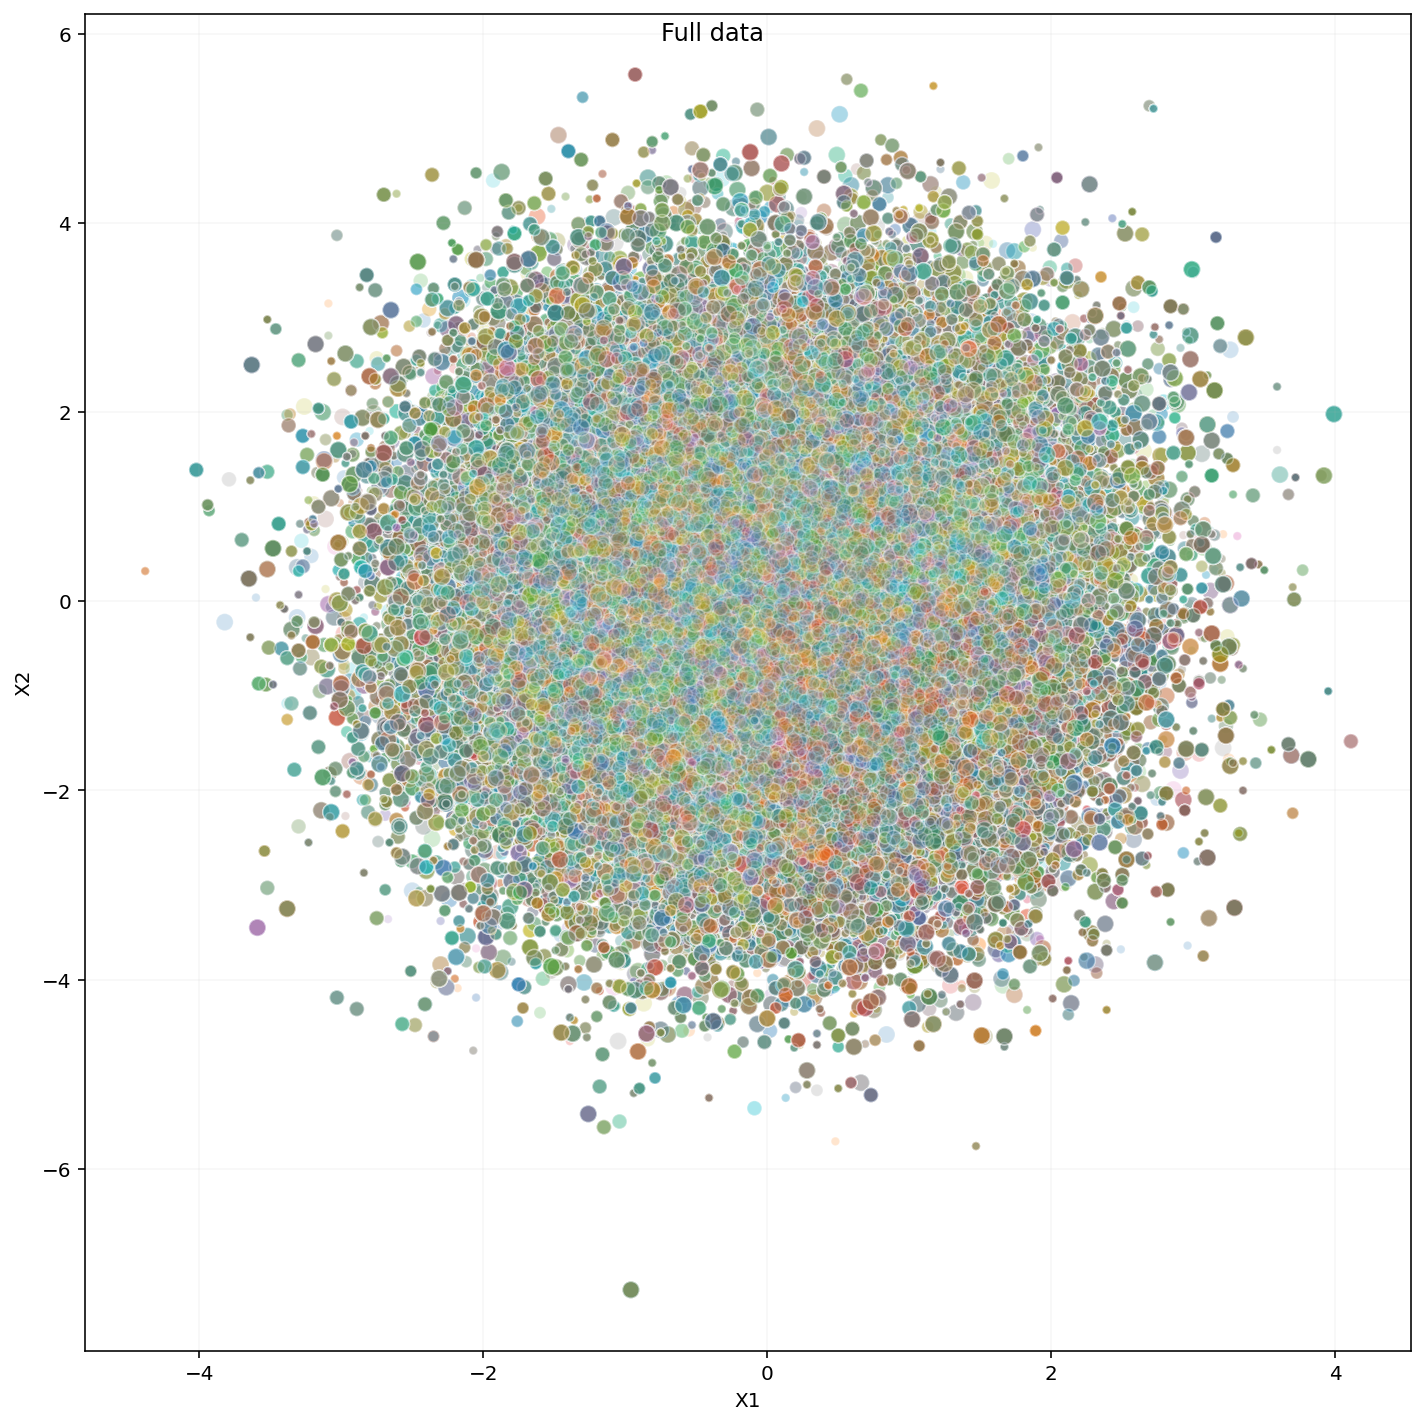

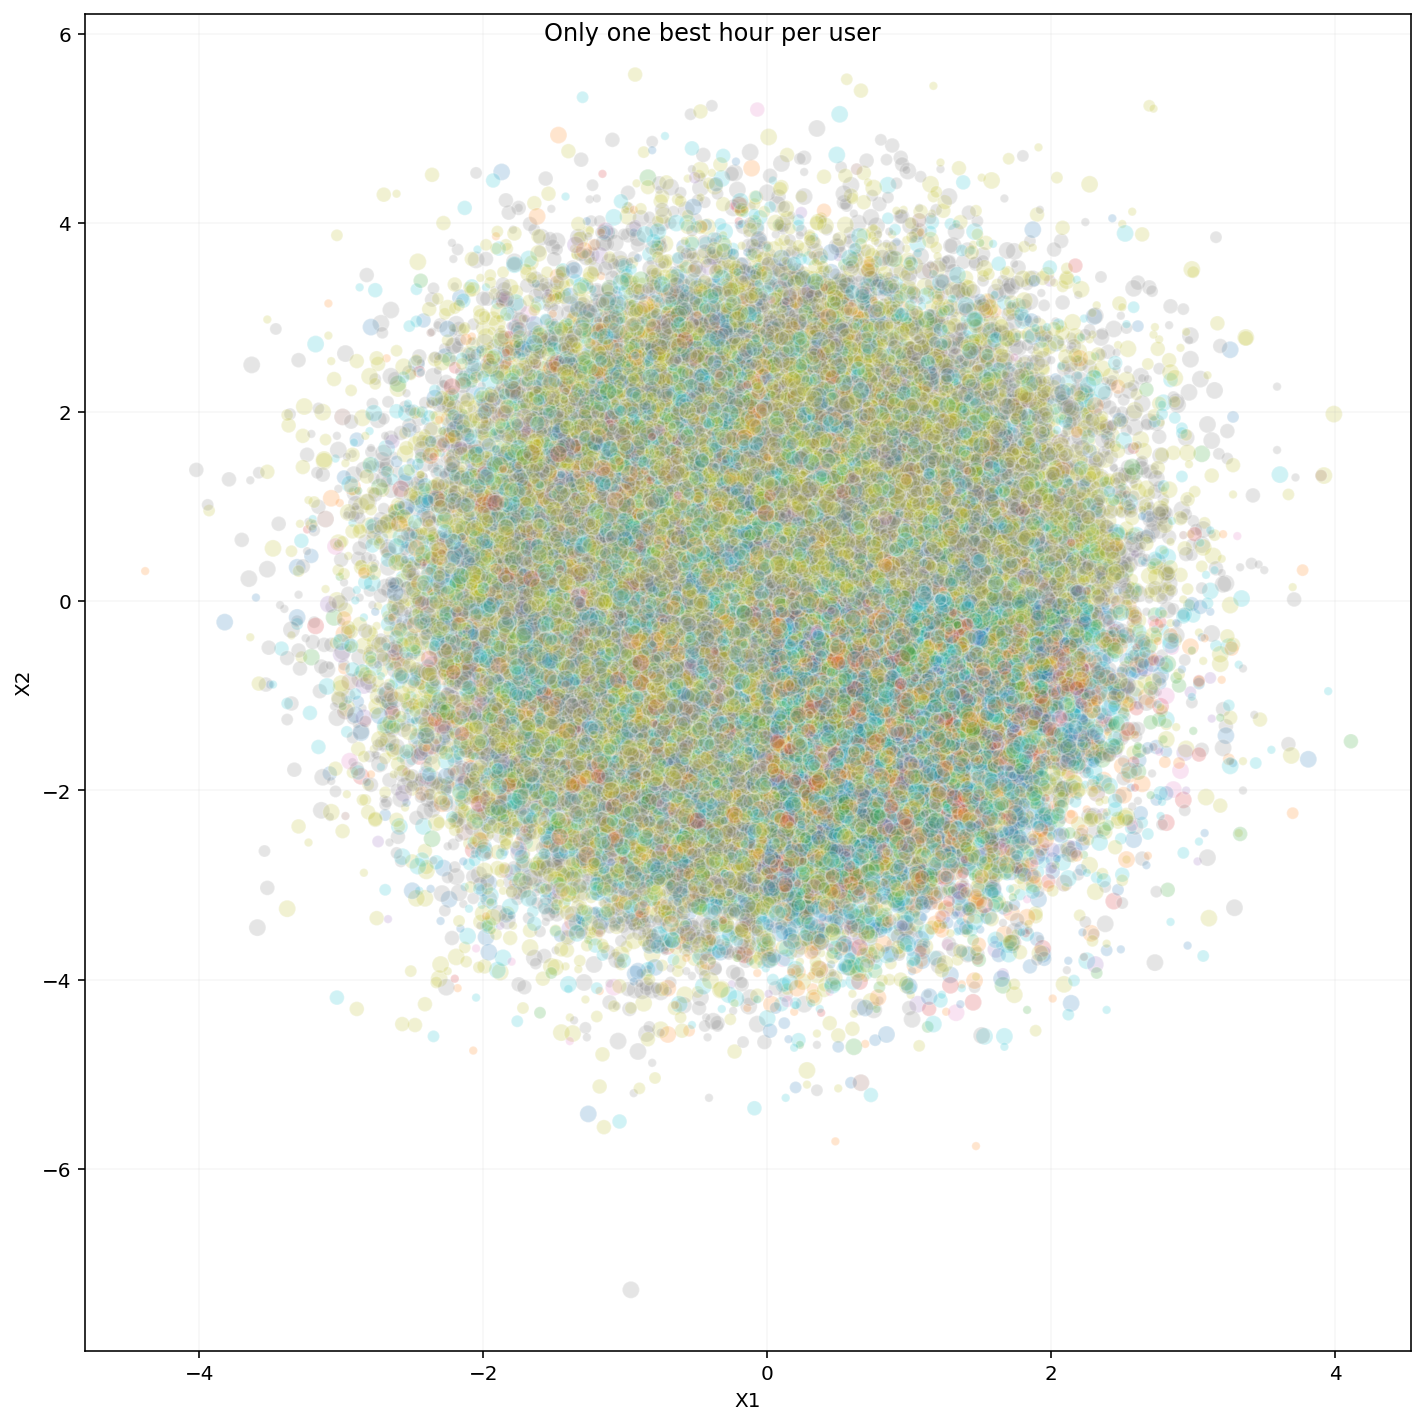

In [12]:
def DataScatter(d,title):
    plt.figure(figsize=(10,10),dpi=144)
    sbn.scatterplot(x='X1',y='X2',hue='OH',size='X3', data=d, alpha=0.2,  palette = 'tab10',legend=False)
    plt.suptitle(title)
    plt.grid(alpha=0.1)
    plt.tight_layout()
    plt.show()
    
DataScatter(df, "Full data")
DataScatter(ndf, "Only one best hour per user")

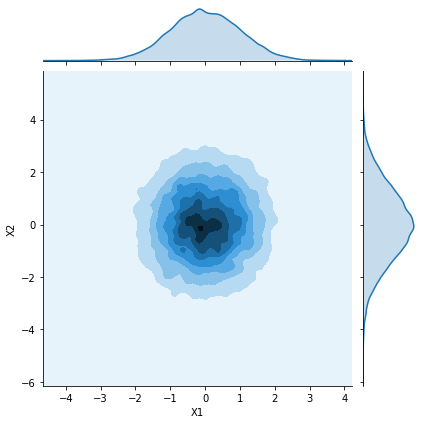

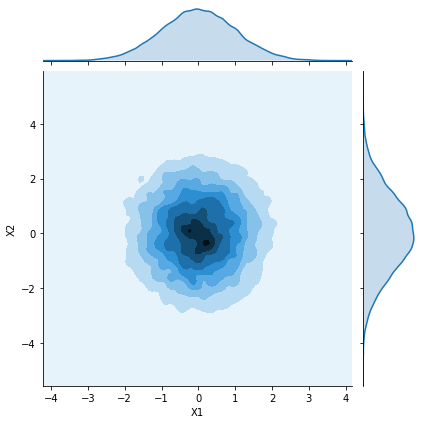

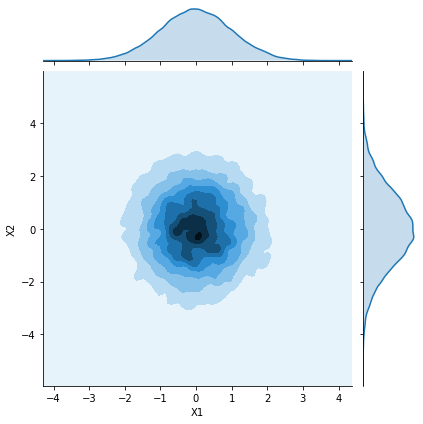

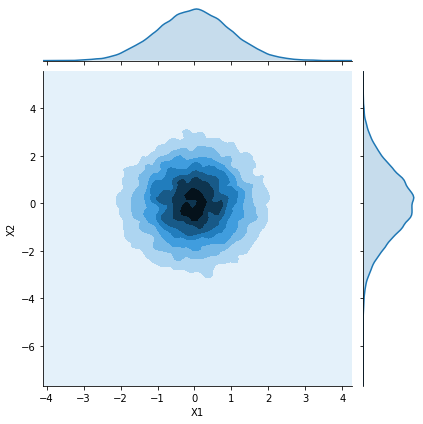

In [13]:
for x3 in range(4):
    sbn.jointplot(x='X1',y='X2',data = df[df.X3==x3],kind='kde')

## The relationship between X1, X2 and the user OH (For each X3)

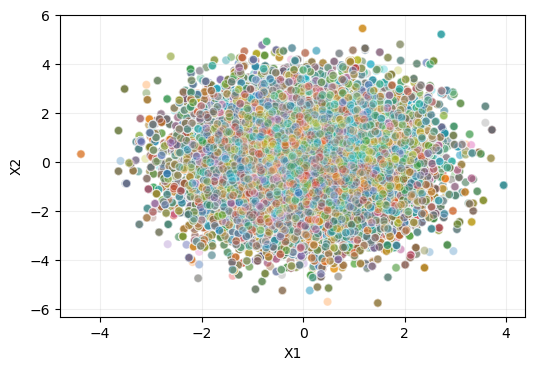

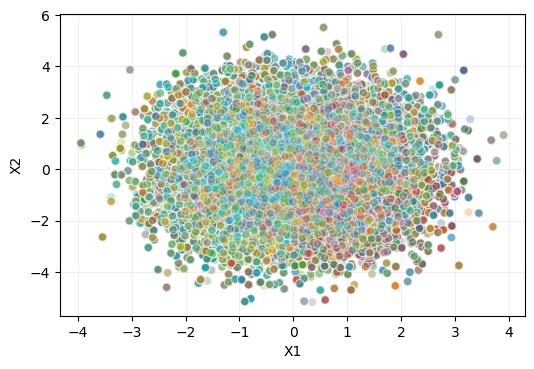

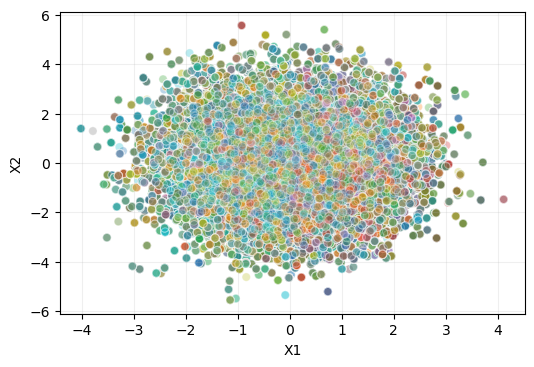

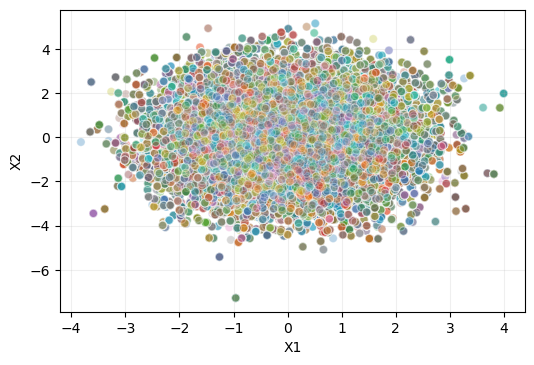

In [14]:
for x3 in range(4):
    plt.figure(dpi=100)
    sbn.scatterplot(x='X1',y='X2',hue='OH',data=df[df.X3==x3],
                    palette='tab10',alpha=0.3,legend=False)
    plt.grid(alpha=0.2)
    plt.show()

### Data cleaning goes in the next cell
The result is the `cdf` data frame which can later be used during the analysis if we find it less confusing for the algorithm

In [15]:
# cdf will be used as the clean version of df
# The reason of using this cleaned version is to check if the cleaning process will impact the final performance
cdf = CleanData(df,0.03)

### Now, let us check the difference.
To see the difference I will check the collision of X1/X2 (the frequency two same X1/X2 pair meet) and show this in a heat map.</br>
This is supposed to generate a visual on their relationship and also the impact of data cleaning (if any).

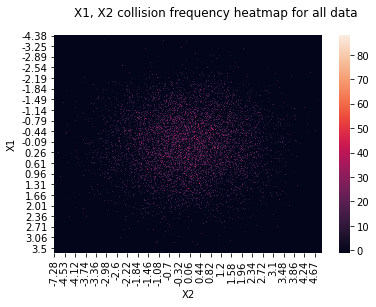

In [16]:
X1X2Heatmap(df,"X1, X2 collision frequency heatmap for all data")

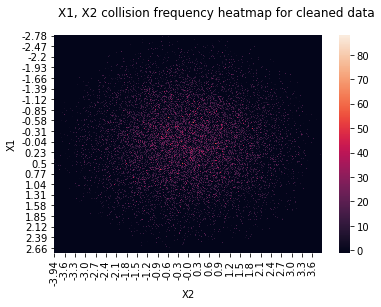

In [17]:
X1X2Heatmap(cdf,"X1, X2 collision frequency heatmap for cleaned data")

### Comparing the measures from `df` and `cdf`

In [18]:
# Measure before cleaning
full = ShowMeasures(df, 'OH','X3')
# Measure after cleaning
split = ShowMeasures(cdf, 'OH','X3')
# Showing differenc
display(full - split)

count      mean       std  min  25%  50%  75%  max
X3                                                        
0.0    7953.0 -0.001219 -0.000495  0.0  0.0  0.0  0.0  0.0
1.0    3981.0 -0.004289  0.000363  0.0  0.0  0.0  0.0  0.0
2.0    4043.0 -0.005793 -0.001528  0.0  0.0  0.0  0.0  0.0
3.0    7982.0  0.000917  0.001472  0.0  0.0  0.0  0.0  0.0
Full  23959.0 -0.002329 -0.005320  0.0  0.0  0.0  0.0  0.0

___
# [1.1] A model to test (Bayes simple code):
In reality, I tried some other options first, and I was lucky to remember that I wrote a suitable 3 years ago. I had to modify a lot of it but her it is.

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

def GetGaussianClassifier(some_data,XCols,YCol,OtherCols=[],scorer=None):
    test_rate = 0.20 
    data = some_data[list(set(XCols + OtherCols + [YCol]))].copy()
    train_x, test_x, train_y, test_y = train_test_split(data[XCols], data[YCol])
    train_idx = train_x.index
    test_idx = test_x.index
    
    model = GaussianNB()
    model.fit(train_x, train_y)
    if scorer is None:
        score = model.scor(test_x,test_y)
    else:        
        score = scorer(data.loc[test_idx,XCols+OtherCols],model.predict(test_x))
    return model,score

def TestX3s(data):
    res = {}
    for x3 in range(4):
        res[x3] = GetGaussianClassifier(data[data.X3==x3],['X1','X2'],'OH',['OH','SH','D'],Evaluate)
    return res

print("Results based on all observations:")
res_df = TestX3s(df)

Results based on all observations:
Suggested sending hours modify avg. delay from 6.16 to 10.05 [-63.16%]
Suggested sending hours modify avg. delay from 11.12 to 9.94 [10.65%]
Suggested sending hours modify avg. delay from 11.11 to 9.79 [11.84%]
Suggested sending hours modify avg. delay from 6.06 to 10.00 [-64.97%]


#### __Results No:1__
__Using Bayesian inference:__</br>
X3 = 0: <span style="color:red">Performance got worse</span></br>
X3 = 1: <span style="color:green">Performance enhanced</span></br>
X3 = 2: <span style="color:green">Performance enhanced</span></br>
X3 = 3: <span style="color:red">Performance got worse</span></br>

### Now, Let us check the impact of using one hour per user
Now, will the Gaussian model learn better in a low noise version of the data?

In [27]:
print("Results based on all observations:")
res_ndf = TestX3s(ndf)

Results based on all observations:
Suggested sending hours modify avg. delay from 7.61 to 2.83 [62.79%]
Suggested sending hours modify avg. delay from 14.04 to 3.44 [75.52%]
Suggested sending hours modify avg. delay from 14.10 to 3.79 [73.09%]
Suggested sending hours modify avg. delay from 7.67 to 2.76 [64.07%]


#### __Results No:2__
__Using Bayesian inference:__</br>
X3 = 0: <span style="color:green">Performance enhanced</span></br>
X3 = 1: <span style="color:green">Performance enhanced</span></br>
X3 = 2: <span style="color:green">Performance enhanced</span></br>
X3 = 3: <span style="color:green">Performance enhanced</span></br>

## <span style="color:red"> __But__ how can we make sure this will also apply to all data available?</span>
In the next cell, I am testing all engines to full data to check the overall performance

In [28]:
for x3 in range(4):
    data = df.copy()
    Evaluate(data,res_df[x3][0].predict(data[['X1','X2']]))

Suggested sending hours modify avg. delay from 8.58 to 10.06 [-17.25%]
Suggested sending hours modify avg. delay from 8.58 to 9.35 [-9.05%]
Suggested sending hours modify avg. delay from 8.58 to 9.17 [-6.87%]
Suggested sending hours modify avg. delay from 8.58 to 9.96 [-16.12%]


In [30]:
for x3 in range(4):
    data = df.copy()
    Evaluate(data,res_ndf[x3][0].predict(data[['X1','X2']]))

Suggested sending hours modify avg. delay from 8.58 to 7.06 [17.67%]
Suggested sending hours modify avg. delay from 8.58 to 7.11 [17.09%]
Suggested sending hours modify avg. delay from 8.58 to 7.09 [17.30%]
Suggested sending hours modify avg. delay from 8.58 to 7.08 [17.44%]


___
# [2] Possible enhancements
Actually I find the solution full of problems if we are planning to use it for real. So, when I add these points for enhancements I suggest more time, more information, more data and more resources. But the most important is time.
1. The performance can be enhanced. Some code I used was written 4 years ago. I copies it from my old archive and revised it to test it with the case. I am sure it can be enhanced more.
2. From usability perspective, code can be prepared in a better way.
3. Having more features that we can use in order to enhance the algorithm(s) understanding of the distributions.
4. More data records may add more aspects to look at.
5. For old people, I think the open time without _date_ might be misleading sometimes, because some of them may check their emails every couple of days.
6. Because of the nature of the situation I kept data files (original and generated) with the notebook file in the same folder. In a real environment this should be different according to each company standards/infrastructure etc.
7. I skipped logging.
8. Of course in real life the long code cells would be saved in .py files to enhance the view and further process integration.
9. For testing speed I have saved copies of already processed data. Function which do the processing to create data will load it if it was already processed before. This approach in real life requires way more checks to make sure we are not by-mistake dealing with obsolete data.
10. Because emails are send every one hour, and on specific hours, I found it not unimportant to keep the minutes from the opening time stamp.
11. I assumed that all email sending/opening took place on a normal day, which means, every user normally opens emails every day on these specific hours. Of course in real life this changes from weekdays to weekends to holidays, summer time, school days based on the user and his/her lifestyle.
___
# Business related enhancements:
1. Using more hours for sending emails will enhance the results of course.
2. Replacing emails with calls/SMS/WhatsApp message etc. when possible. This will of course require some new details to be added to the CRM and the teams structure, but at the same time can add much to the overall process performance.
3. Delay of opening an email does not usually mean the user did not check the subject. For repeated/frequent/scheduled emails, many users start to avoid opening the emails, and just read the subject, then read it later. So, it might also be useful to have data about emails that were never opened because studying it might generate some good insight to enhance the overall process.
___
___